In [107]:
import os
import glob
import pandas as pd 
import numpy as np
import math
#import plotnine as p9
import matplotlib.pyplot as plt
try :
    import seaborn as sns
except : 
    ! pip install seaborn
    import seaborn as sns
try :
    import nibabel as nib
except : 
    ! pip install nibabel
    import nibabel as nib

# Chargement des données propre à l'étude

In [108]:
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII")
SCRIPT_PATH=os.path.join(STUDY_PATH,'scripts')
LOG_PATH=os.path.join(SCRIPT_PATH,'log')
DATA_FILE=os.path.join(STUDY_PATH,"AdrianPiotto_M1",'DataAnxAP.xlsx')
CQ_FILE=os.path.join(STUDY_PATH,'FairparkII_MRIData_20210817.xlsx')

In [109]:
CQData = pd.read_excel(CQ_FILE,index_col=0,engine='openpyxl')
CLIData = pd.read_excel(DATA_FILE,index_col=0,engine='openpyxl')

In [110]:
# Filtrer les individus avec un score "MDS1 1.4" > 0
filtered_data = CLIData[CLIData['MDS 1.4'] > 0]
# Compter le nombre d'individus
count = filtered_data.shape[0]
print(f"Nombre d'individus avec un score de 'MDS1 1.4' > 0 : {count}")

Nombre d'individus avec un score de 'MDS1 1.4' > 0 : 114


In [111]:
CLIData['ANX'] = CLIData['MDS 1.4'].apply(lambda x: 1 if x > 0 else 0)
CLIData.index = CLIData.index.str.replace('^sub-', '', regex=True).str.replace('_ses-W00$', '', regex=True)

In [112]:
df_W00=CQData.query("SUBJ.str.endswith('W00')")
df_W00.index=df_W00.index.str[:-8]

# Filtrer df_W00 pour obtenir les sujets avec QC_3DT1 > 1
filtered_df_W00 = df_W00[df_W00['QC_3DT1'] > 1]

# Faire une jointure entre CLIData et filtered_df_W00 sur l'index


In [113]:
merged_data = CLIData.merge(filtered_df_W00, left_index=True, right_index=True, how='inner')

In [114]:
merged_data['Sexe']=merged_data['Sexe'].replace({1:'M',0:'F'}) # a verifier que c'est bien ca
merged_data['GROUP_NAME']=merged_data['ANX'].replace({1:'ANX',0:'NO_ANX'})
merged_data= merged_data.rename_axis("SUBJ")

In [115]:
# Création du dictionnaire
regions_dict = {
    "amygdale gauche": 32,
    "amygdale droite": 31,
    "caudé gauche": 37,
    "caudé droit": 36,
    "putamen gauche": 58,
    "putamen droit": 57,
    "accumbens gauche": 30,
    "accumbens droit": 23,
    "thalamus gauche": 60,
    "thalamus droit": 59,
}

# Affichage du dictionnaire pour vérification
print(regions_dict)

{'amygdale gauche': 32, 'amygdale droite': 31, 'caudé gauche': 37, 'caudé droit': 36, 'putamen gauche': 58, 'putamen droit': 57, 'accumbens gauche': 30, 'accumbens droit': 23, 'thalamus gauche': 60, 'thalamus droit': 59}


In [116]:
# Initialiser un DataFrame pour stocker les volumes, les valeurs moyennes du signal et les quantiles du signal
columns = ['Volume', 'Mean_Signal', '1%', '25%', '50%', '75%', '99%']
data = pd.DataFrame(index=merged_data.index, columns=pd.MultiIndex.from_product([regions_dict.keys(), columns]))

# Parcourir chaque sujet du DataFrame
for subject in merged_data.index:
    # Construire le chemin du dossier contenant les fichiers NIfTI
    nifti_folder = os.path.join(STUDY_PATH, "Volbrain_Seg_V2", f'sub_{subject}_ses_W00')
    
    # Utiliser glob pour trouver le fichier NIfTI correspondant
    nifti_files = glob.glob(os.path.join(nifti_folder, 'native_structures_std_native_n_mmni_fjob*.nii.gz'))
    
    if nifti_files:
        # Charger l'image NIfTI
        img = nib.load(nifti_files[0])
        img_data = img.get_fdata()
        
        # Calculer le volume pour chaque région
        for region, value in regions_dict.items():
            region_volume = np.sum(img_data == value)
            data.loc[subject, (region, 'Volume')] = region_volume
    else:
        # Si aucun fichier n'est trouvé, ajouter des valeurs NaN
        for region in regions_dict.keys():
            data.loc[subject, (region, 'Volume')] = np.nan

    # Construire le chemin du fichier T2Map
    t2map_file = os.path.join(STUDY_PATH, "T2Maps", f'rRAS_R2Map_sub-{subject}_ses-W00.nii.gz')
    
    if os.path.exists(t2map_file):
        # Charger l'image T2Map
        t2map_img = nib.load(t2map_file)
        t2map_data = t2map_img.get_fdata()
        if t2map_data.shape == img_data.shape:
            # Calculer la valeur moyenne du signal et les quantiles pour chaque région
            for region, value in regions_dict.items():
                region_mask = (img_data == value)
                if np.any(region_mask):
                    mean_signal = np.mean(t2map_data[region_mask])
                    quantiles_1_99 = np.percentile(t2map_data[region_mask], [1, 25, 50, 75, 99])
                    data.loc[subject, (region, 'Mean_Signal')] = mean_signal
                    data.loc[subject, (region, '1%')] = quantiles_1_99[0]
                    data.loc[subject, (region, '25%')] = quantiles_1_99[1]
                    data.loc[subject, (region, '50%')] = quantiles_1_99[2]
                    data.loc[subject, (region, '75%')] = quantiles_1_99[3]
                    data.loc[subject, (region, '99%')] = quantiles_1_99[4]
                else:
                    data.loc[subject, (region, 'Mean_Signal')] = np.nan
                    data.loc[subject, (region, '1%')] = np.nan
                    data.loc[subject, (region, '25%')] = np.nan
                    data.loc[subject, (region, '50%')] = np.nan
                    data.loc[subject, (region, '75%')] = np.nan
                    data.loc[subject, (region, '99%')] = np.nan
        else:
            print(f"Les dimensions de l'image T2Map et de l'image segmentée ne correspondent pas pour le sujet {subject}")
    else:
        for region in regions_dict.keys():
            data.loc[subject, (region, 'Mean_Signal')] = np.nan
            data.loc[subject, (region, '1%')] = np.nan
            data.loc[subject, (region, '25%')] = np.nan
            data.loc[subject, (region, '50%')] = np.nan
            data.loc[subject, (region, '75%')] = np.nan
            data.loc[subject, (region, '99%')] = np.nan

# Afficher le DataFrame pour vérification
print(data.head())


Les dimensions de l'image T2Map et de l'image segmentée ne correspondent pas pour le sujet 103019HS
         amygdale gauche                                                      \
                  Volume Mean_Signal        1%       25%       50%       75%   
SUBJ                                                                           
101001YM             973    0.023836  0.019625  0.022938  0.023833  0.024795   
101002GX            1273         NaN       NaN       NaN       NaN       NaN   
101003DM            1290    0.023452   0.01904  0.021811   0.02325  0.024783   
101004NW            1001    0.024349   0.01921  0.023077  0.024526  0.025748   
101005CT            1335    0.023521  0.019685   0.02209  0.023246  0.024576   

                   amygdale droite                        ... thalamus gauche  \
               99%          Volume Mean_Signal        1%  ...             50%   
SUBJ                                                      ...                   
101001YM   0.027

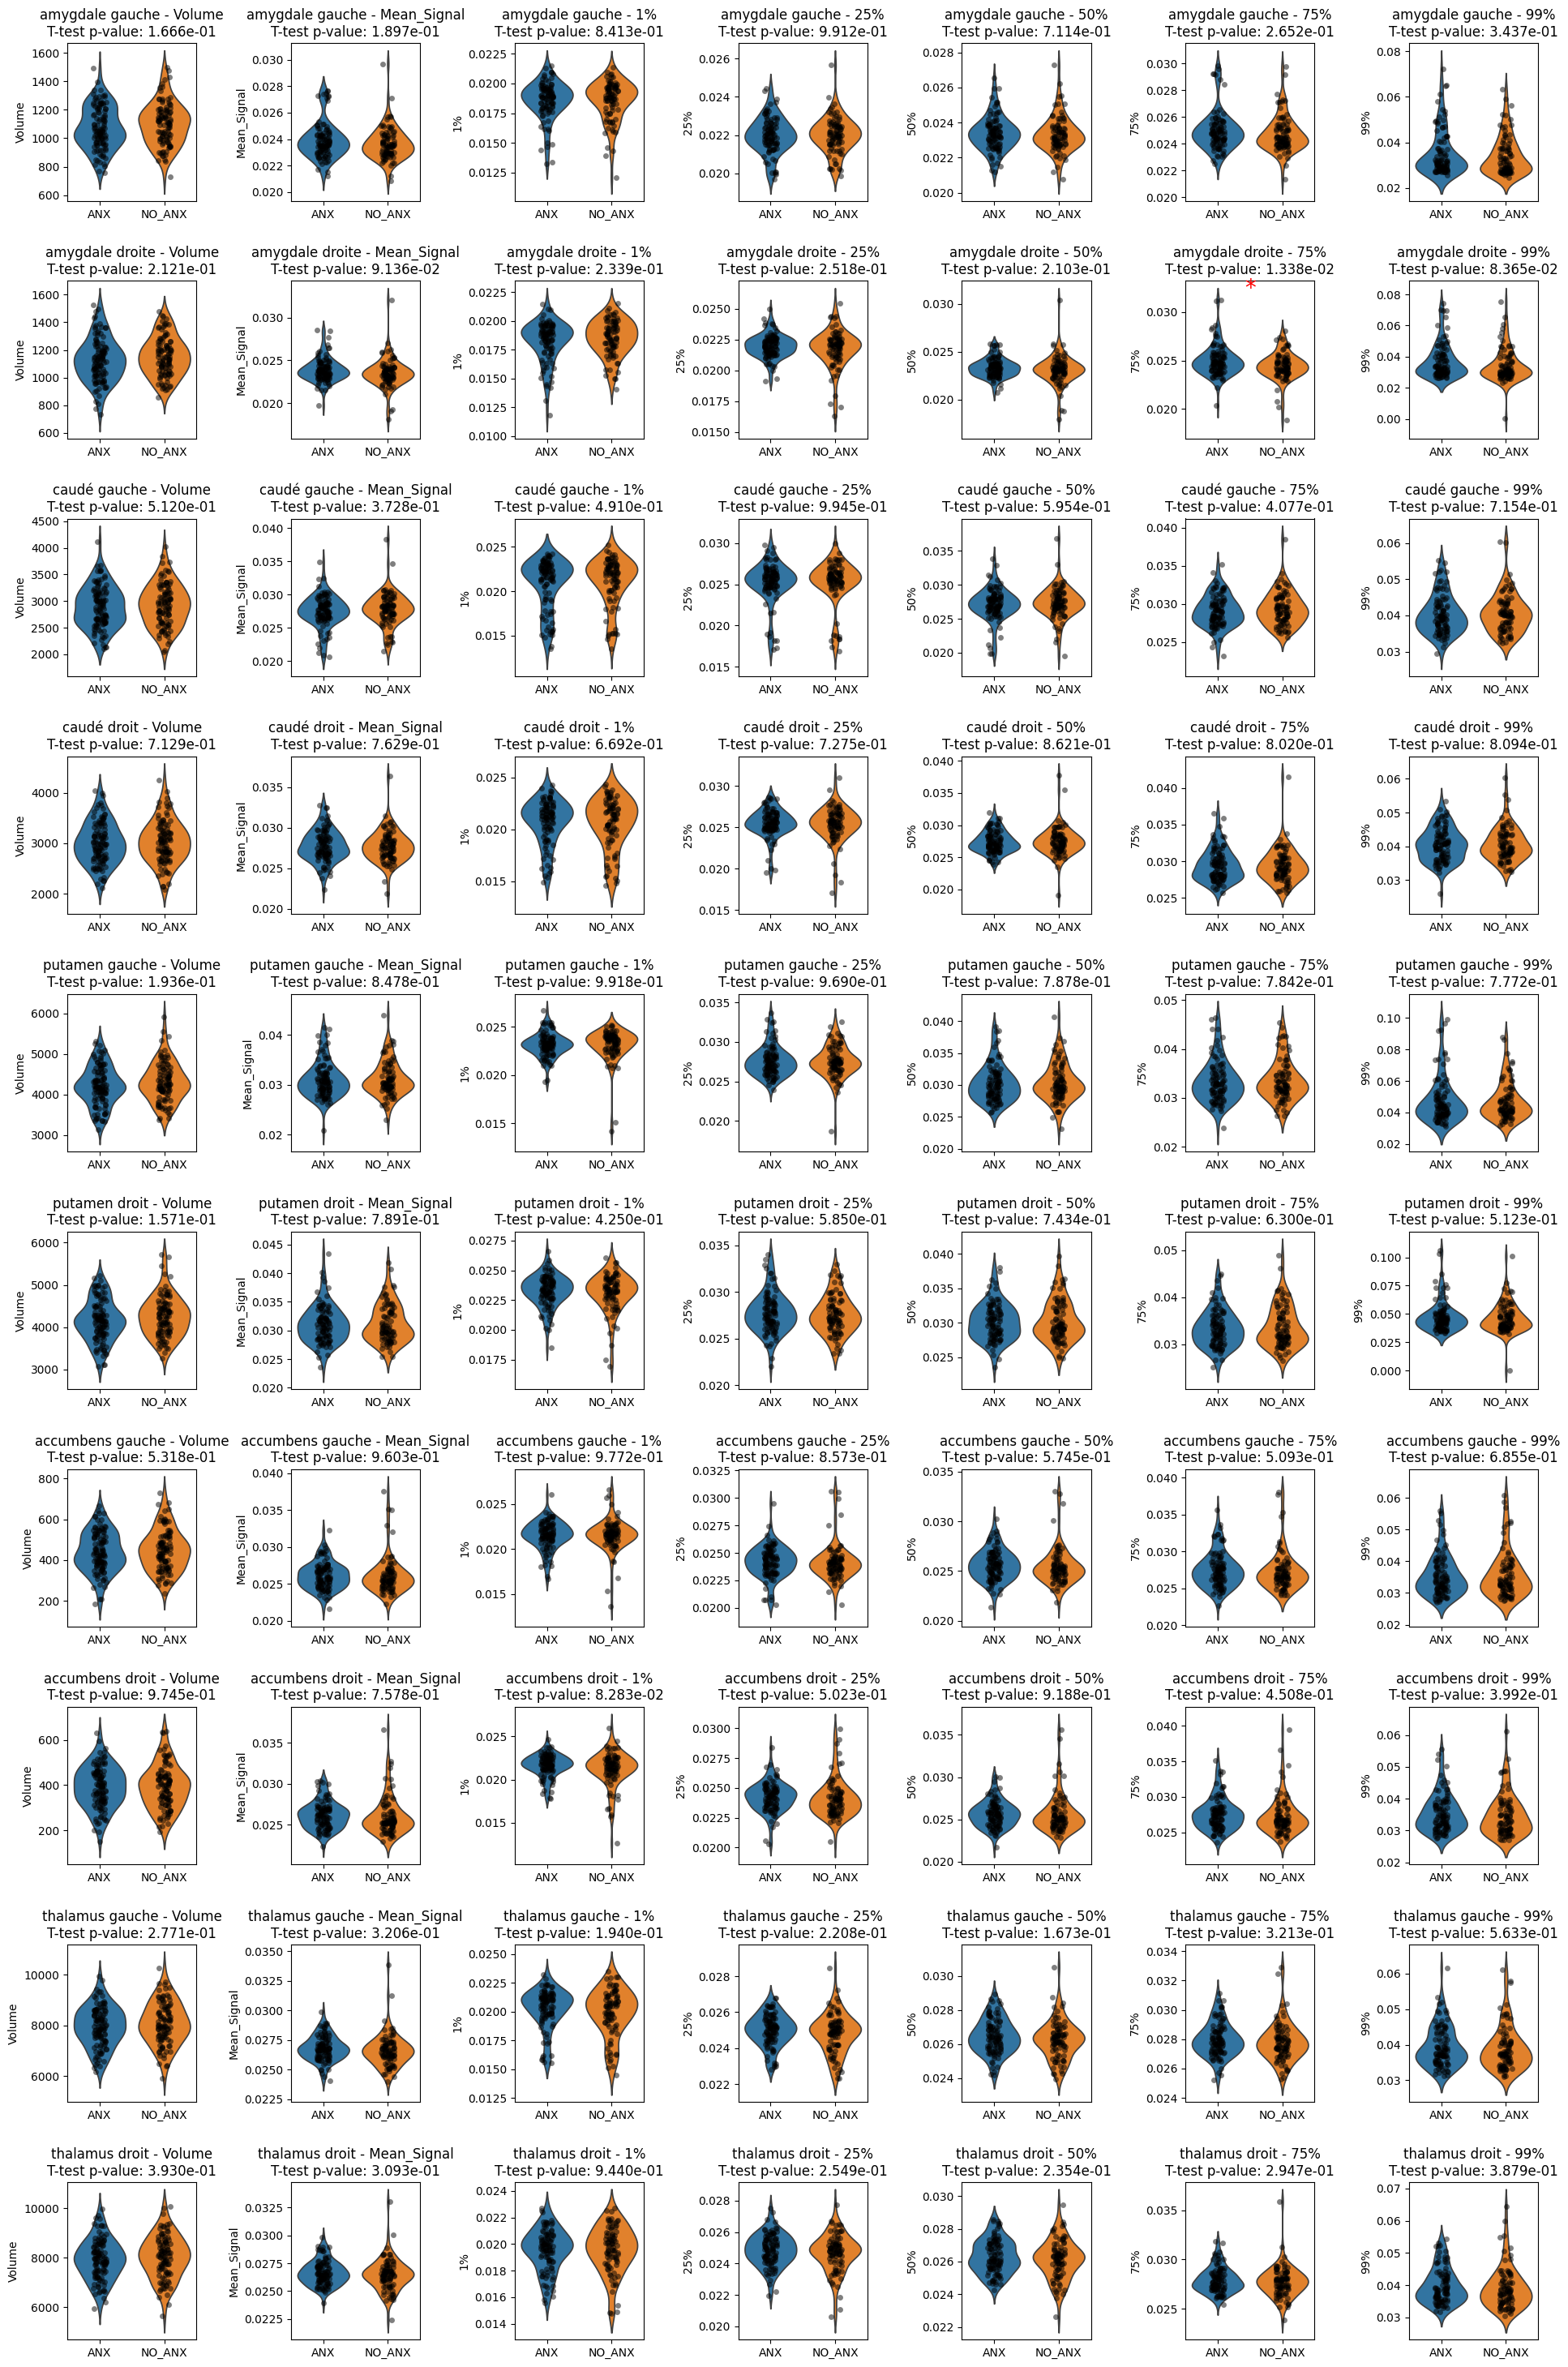

In [117]:
from scipy.stats import ttest_ind

# Créer une figure et des axes pour les plots
fig, axes = plt.subplots(nrows=len(regions_dict), ncols=len(columns), figsize=(20, 30))
fig.tight_layout(pad=5.0)

# Parcourir chaque région et chaque colonne
for i, region in enumerate(regions_dict.keys()):
    for j, column in enumerate(columns):
        ax = axes[i, j]
        
        # Créer un dataframe temporaire pour la région et la colonne actuelle
        temp_df = merged_data[['GROUP_NAME']].copy()
        temp_df[column] = data[(region, column)].astype(float)
        
        # Supprimer les outliers
        group1 = temp_df[temp_df['GROUP_NAME'] == 'ANX'][column].dropna()
        group2 = temp_df[temp_df['GROUP_NAME'] == 'NO_ANX'][column].dropna()
        
        mean1, std1 = group1.mean(), group1.std()
        mean2, std2 = group2.mean(), group2.std()
        
        group1 = group1[(group1 >= mean1 - 3 * std1) & (group1 <= mean1 + 3 * std1)]
        group2 = group2[(group2 >= mean2 - 3 * std2) & (group2 <= mean2 + 3 * std2)]
        
        temp_df = temp_df[temp_df[column].isin(group1) | temp_df[column].isin(group2)]
        
        # Créer les plots
        sns.violinplot(x='GROUP_NAME', y=column, data=temp_df, ax=ax, inner=None,hue='GROUP_NAME')#, palette={0: 'blue', 1: 'orange'})
        #sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())
        sns.stripplot(x='GROUP_NAME', y=column, data=temp_df, ax=ax, color='k', alpha=0.5)
        
        # Effectuer le test de Student
        t_stat, p_val = ttest_ind(group1, group2)
        
        # Ajouter le titre avec le p-value
        ax.set_title(f'{region} - {column}\nT-test p-value: {p_val:.3e}')
        
        # Ajouter une étoile si la p-value est significative
        if p_val < 0.05:
            ax.text(0.5, 0.95, '*', ha='center', va='center', transform=ax.transAxes, fontsize=20, color='red')
        
        # Ajuster les labels
        ax.set_ylabel(column)
        ax.set_xlabel("")

fig.savefig('/NAS/dumbo/protocoles/FAIRPARKII/screenshots/VolumeAndR2_ANX_NoANx.png')

# Afficher la figure
plt.show()

In [118]:
# Initialiser une liste pour stocker les DataFrames
dfs = []

# Parcourir chaque sujet dans merged_data
for subject in merged_data.index:
    # Construire le chemin du fichier CSV
    csv_file = glob.glob(os.path.join(STUDY_PATH, "Volbrain_Seg_V2", f"sub_{subject}_ses_W00", "report_std_native_n_mmni_*.csv"))
    if csv_file:
        # Lire le fichier CSV et l'ajouter à la liste
        df = pd.read_csv(csv_file[0], sep=';')
        df['SUBJ'] = subject  # Ajouter une colonne pour le sujet
        dfs.append(df)

# Concaténer tous les DataFrames en un seul
all_reports_df = pd.concat(dfs, ignore_index=True)

# Afficher le DataFrame pour vérification
print(all_reports_df.head())

                        Subject      Sex      Age  Report date  \
0  std_native_n_mmni_fjob322361  UNKNOWN  UNKNOWN  10-Jun-2022   
1  std_native_n_mmni_fjob322999  UNKNOWN  UNKNOWN  15-Jun-2022   
2  std_native_n_mmni_fjob323003  UNKNOWN  UNKNOWN  10-Jun-2022   
3  std_native_n_mmni_fjob322452  UNKNOWN  UNKNOWN  10-Jun-2022   
4  std_native_n_mmni_fjob322919  UNKNOWN  UNKNOWN  10-Jun-2022   

  Image orientation  Scale factor        SNR Quality control  \
0      Neurological      0.732392  73.146223               A   
1      Neurological      0.878567  78.138746               A   
2      Neurological      0.847353  64.978931               A   
3      Neurological      0.750352  67.264093               A   
4      Neurological      0.904540  79.480395               A   

   White Matter (WM) volume cm3  White Matter (WM) volume %  ...  \
0                    405.761771                   31.131149  ...   
1                    429.016446                   27.364606  ...   
2             

In [119]:
# Mettre la colonne 'SUBJECT' comme clé
all_reports_df.set_index('SUBJ', inplace=True)
all_reports_df.drop(all_reports_df.columns[:4], axis=1, inplace=True)
# Afficher le DataFrame pour vérification
print(all_reports_df.head())

         Image orientation  Scale factor        SNR Quality control  \
SUBJ                                                                  
101001YM      Neurological      0.732392  73.146223               A   
101002GX      Neurological      0.878567  78.138746               A   
101003DM      Neurological      0.847353  64.978931               A   
101004NW      Neurological      0.750352  67.264093               A   
101005CT      Neurological      0.904540  79.480395               A   

          White Matter (WM) volume cm3  White Matter (WM) volume %  \
SUBJ                                                                 
101001YM                    405.761771                   31.131149   
101002GX                    429.016446                   27.364606   
101003DM                    501.698115                   30.915744   
101004NW                    433.644405                   31.260889   
101005CT                    513.054438                   30.612725   

          G

In [120]:
# Fusionner all_reports_df avec merged_data sur l'index
final_merged_data = merged_data.merge(all_reports_df, left_index=True, right_index=True, how='inner')

# Afficher le DataFrame fusionné pour vérification
print(final_merged_data.head())

          MDS 1.4  Age Sexe  CentreAqui  NB_YEAR_SCHO  ANX  QC_3DT1  \
SUBJ                                                                  
101001YM        2   63    F           3          16.0    1        3   
101002GX        0   74    M           3          11.0    0        3   
101003DM        3   59    M           3          14.0    1        4   
101004NW        1   67    F           3          15.0    1        4   
101005CT        0   56    M           3          17.0    0        4   

          QC_3DMULTI  RV_CQ_ORIENTATION GROUP_NAME  ...  \
SUBJ                                                ...   
101001YM           4                NaN        ANX  ...   
101002GX           0                NaN     NO_ANX  ...   
101003DM           4                NaN        ANX  ...   
101004NW           4                NaN        ANX  ...   
101005CT           4                NaN     NO_ANX  ...   

         4th ventricle volume cm3  4th ventricle volume %  \
SUBJ                       

In [124]:
columns_of_interest = [col for col in all_reports_df.columns if any(keyword in col for keyword in ['Caudate', 'Putamen', 'Accumbens', 'Thalamus'])]
columns_of_interest

['Accumbens total volume cm3',
 'Accumbens total volume %',
 'Accumbens right volume cm3',
 'Accumbens right volume %',
 'Accumbens left volume cm3',
 'Accumbens left volume %',
 'Accumbens volume asymmetry',
 'Caudate total volume cm3',
 'Caudate total volume %',
 'Caudate right volume cm3',
 'Caudate right volume %',
 'Caudate left volume cm3',
 'Caudate left volume %',
 'Caudate volume asymmetry',
 'Putamen total volume cm3',
 'Putamen total volume %',
 'Putamen right volume cm3',
 'Putamen right volume %',
 'Putamen left volume cm3',
 'Putamen left volume %',
 'Putamen volume asymmetry',
 'Thalamus total volume cm3',
 'Thalamus total volume %',
 'Thalamus right volume cm3',
 'Thalamus right volume %',
 'Thalamus left volume cm3',
 'Thalamus left volume %',
 'Thalamus volume asymmetry']

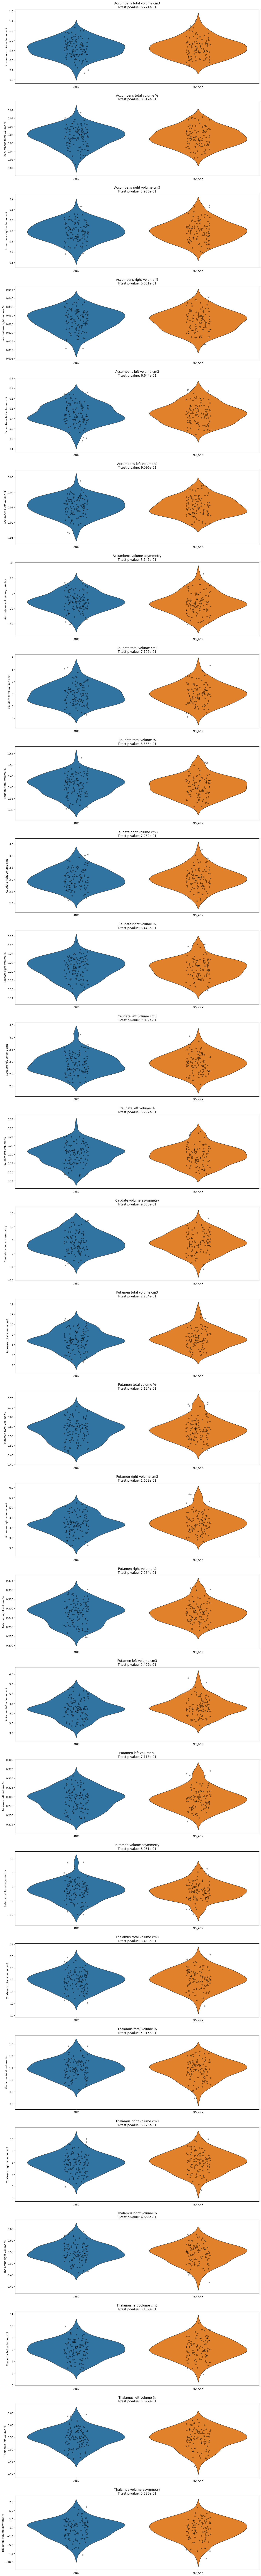

In [125]:
# Créer une figure et des axes pour les plots
fig, axes = plt.subplots(nrows=len(columns_of_interest), ncols=1, figsize=(15, len(columns_of_interest) * 5))
fig.tight_layout(pad=5.0)

# Parcourir chaque colonne d'intérêt
for i, column in enumerate(columns_of_interest):
    ax = axes[i]
    
    # Créer un dataframe temporaire pour la colonne actuelle
    temp_df = final_merged_data[['GROUP_NAME', column]].dropna()
    
    # Supprimer les outliers
    group1 = temp_df[temp_df['GROUP_NAME'] == 'ANX'][column]
    group2 = temp_df[temp_df['GROUP_NAME'] == 'NO_ANX'][column]
    
    mean1, std1 = group1.mean(), group1.std()
    mean2, std2 = group2.mean(), group2.std()
    
    group1 = group1[(group1 >= mean1 - 3 * std1) & (group1 <= mean1 + 3 * std1)]
    group2 = group2[(group2 >= mean2 - 3 * std2) & (group2 <= mean2 + 3 * std2)]
    
    temp_df = temp_df[temp_df[column].isin(group1) | temp_df[column].isin(group2)]
    
    # Créer les plots
    sns.violinplot(x='GROUP_NAME', y=column, data=temp_df, ax=ax, inner=None, hue='GROUP_NAME')
    sns.stripplot(x='GROUP_NAME', y=column, data=temp_df, ax=ax, color='k', alpha=0.5)
    
    # Effectuer le test de Student
    t_stat, p_val = ttest_ind(group1, group2)
    
    # Ajouter le titre avec le p-value
    ax.set_title(f'{column}\nT-test p-value: {p_val:.3e}')
    
    # Ajouter une étoile si la p-value est significative
    if p_val < 0.05:
        ax.text(0.5, 0.95, '*', ha='center', va='center', transform=ax.transAxes, fontsize=20, color='red')
    
    # Ajuster les labels
    ax.set_ylabel(column)
    ax.set_xlabel("")

# Sauvegarder la figure
fig.savefig('/NAS/dumbo/protocoles/FAIRPARKII/screenshots/Volume_ANX_NoANx.png')

# Afficher la figure
plt.show()


In [126]:
# Sauvegarder final_merged_data au format CSV
final_merged_data.to_csv('/NAS/dumbo/protocoles/FAIRPARKII/Volume_ANX_NoANx.csv', index=True)


In [127]:
data.to_excel('/NAS/dumbo/protocoles/FAIRPARKII/VolumeAndR2_ANX_NoANx.xlsx', index=True)